## Import & 데이터 불러오기

In [1]:
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns
import re
from tqdm import tqdm
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import os
import collections
import gensim
from gensim import corpora, models
from gensim.models import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from wordcloud import WordCloud
import nltk
from matplotlib import font_manager,rc

%matplotlib inline

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/nltk/decorators.py:68: DeprecationWarning: `formatargspec` is deprecated since Python 3.5. Use `signature` and the `Signature` object directly
  regargs, varargs, varkwargs, defaults, formatvalue=lambda value: ""
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/counter.py:15: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Sequence, defaultdict
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/nltk/lm/vocabulary.py:13: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Counter, Iterable


#### 3개로 군집화 된 데이터 불러오기

In [2]:
covid = pd.read_csv('[코로나] 3cluster.csv', parse_dates=['제안일자','의결일자'])
covid = covid.drop(['Unnamed: 0','텍스트','명사수','문장벡터'],axis=1)
covid['제안일자'] = covid['제안일자'].dt.month
covid['의결일자'] = covid['의결일자'].dt.month

In [3]:
# ['토큰'] 칼럼 콤마 기준 스플릿

for i in range(len(covid)):

    covid_tocken=[]

    covid['토큰'][i] = covid['토큰'][i][1:-1].split(', ')
    for j in covid['토큰'][i]:
        covid_tocken.append(j[1:-1])

    covid['토큰'][i] = covid_tocken
    

# ['제안정당'] 칼럼 콤마 기준 스플릿

for i in range(len(covid)):

    partylist=[]

    covid['제안정당'][i] = covid['제안정당'][i][1:-1].split(', ')
    for j in covid['제안정당'][i]:
        partylist.append(j[1:-1])

    covid['제안정당'][i] = partylist

/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/ojoo/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-co

#### 카테고리 별로 데이터 나누기

In [4]:
# category == 0
covid_0 = covid[covid['category']==0]
covid_0 = covid_0.reset_index(drop=True)

# category == 1
covid_1 = covid[covid['category']==1]
covid_1 = covid_1.reset_index(drop=True)

# category == 2
covid_2 = covid[covid['category']==2]
covid_2 = covid_2.reset_index(drop=True)

## 2. '코로나' 관련 전체 데이터 분석

### ① '코로나' 관련 의안 수 확인

In [5]:
len(covid)

389

전체 의안 수 =  25222(20대) + 4254(21대) = 29476개

In [6]:
389/29476

0.013197177364635635

**2020-01-01~2020-08-24/ 전체 의안 중 코로나 관련 의안이 차지하는 비율 => 13%**

### ② 월별 코로나 관련 법안 발의 건수

In [11]:
def billdate_vis(df, name): 
    
    %matplotlib inline

    rc('font', family='AppleGothic')

    plt.rcParams['axes.unicode_minus'] = False
    
    date = pd.DataFrame(df.groupby('제안일자')['의안번호'].count())
    plt.figure(figsize = (30,6))
    plt.xticks(rotation = - 45)
    sns.pointplot(data = date, x=date.index, y='의안번호')
    plt.title(f'2020년 이후 월별 {name} 관련 법안 발의 건수', fontsize=25)

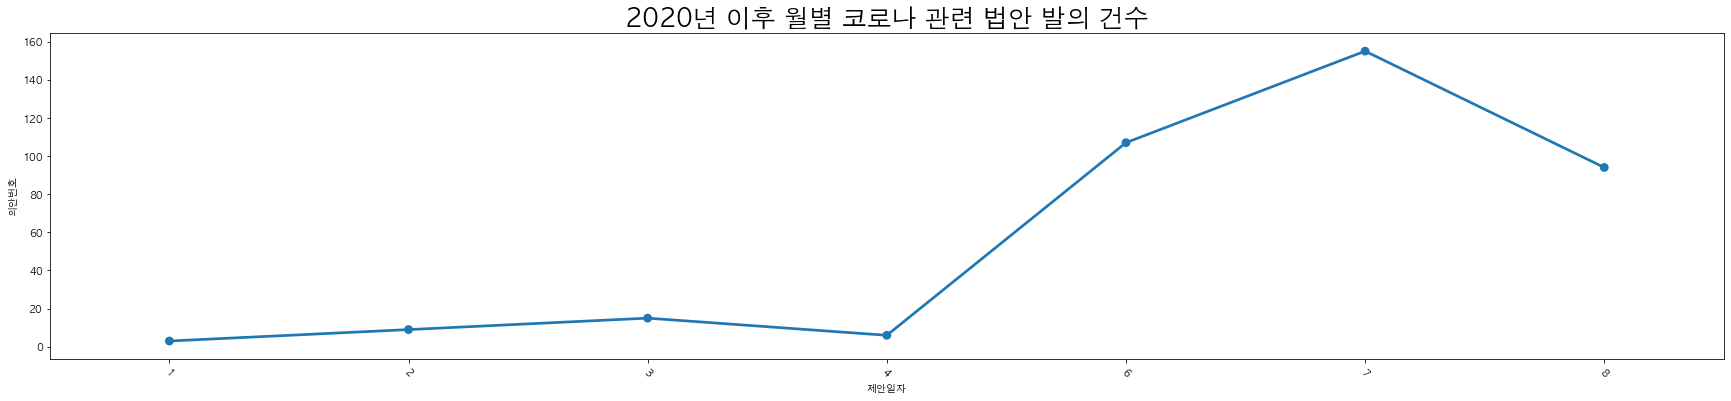

In [12]:
billdate_vis(covid, '코로나')

### ③ 소관위원회 value_counts

In [13]:
covid['소관위원회'].value_counts()

기획재정위원회            115
보건복지위원회             63
행정안전위원회             46
환경노동위원회             36
교육위원회               32
산업통상자원중소벤처기업위원회     25
문화체육관광위원회           22
법제사법위원회             13
국토교통위원회             13
과학기술정보방송통신위원회        9
정무위원회                9
농림축산식품해양수산위원회        5
외교통일위원회              1
Name: 소관위원회, dtype: int64

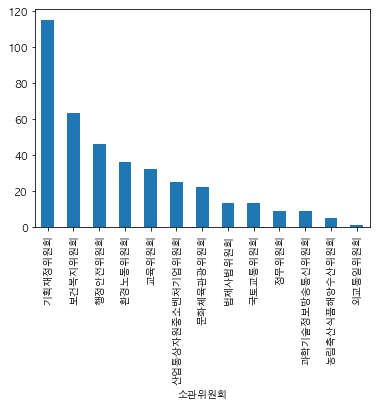

In [14]:
# 시각화

covid_comm = covid.groupby(['소관위원회'])['의안번호'].count()
covid_comm = covid_comm.sort_values(ascending=False)
covid_comm.plot.bar()

### ④ 소관위원회별 법률공포 여부 분석

In [15]:
proclaim_list = ['원안가결', '수정가결']
reject_list = ['임기만료폐기', '대안반영폐기', '철회', '폐기', '부결', '수정안반영폐기','계류']

covid.loc[covid['의결결과'].isin(proclaim_list), '법률공포여부'] = '공포'
covid.loc[covid['의결결과'].isin(reject_list), '법률공포여부'] = '미공포'

covid['법률공포여부'].value_counts()

미공포    38
공포      5
Name: 법률공포여부, dtype: int64

In [16]:
covid['의결결과'].isna().sum()

346

**=> 의결결과가 아직 없는 의안이 많아서 공포여부 분석이 의미가 없어보인다!**

In [17]:
comm = pd.DataFrame(covid.groupby('소관위원회')['법률공포여부'].value_counts()).unstack().fillna(0)
comm.reset_index(inplace=True)
comm.columns = ['소관위원회','공포','미공포']
comm['합계'] = comm['공포'] + comm['미공포']
comm['공포율'] = np.round((comm['공포'] / comm['합계']) * 100)
comm.sort_values(by='공포율', ascending=False)

,소관위원회,공포,미공포,합계,공포율
4,보건복지위원회,3.0,12.0,15.0,20.0
6,행정안전위원회,1.0,5.0,6.0,17.0
2,기획재정위원회,1.0,12.0,13.0,8.0
0,교육위원회,0.0,1.0,1.0,0.0
1,국토교통위원회,0.0,4.0,4.0,0.0
3,문화체육관광위원회,0.0,1.0,1.0,0.0
5,산업통상자원중소벤처기업위원회,0.0,1.0,1.0,0.0
7,환경노동위원회,0.0,2.0,2.0,0.0


In [18]:
covid.head(3)

,Unnamed: 0.1,의안번호,처리여부,의안명,제안자구분,제안일자,의결일자,의결결과,심사진행상태,문서,제안회기,제안이유,소관위원회,제안자,법률안,제안정당,법률공포여부,토큰,category
0,0,2024549,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,1,2.0,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,최근 신종 코로나바이러스감염증(2019 novel Coronavirus 2019 ...,보건복지위원회,"[""['유의동(새로운보수당/兪義東)'"", "" '권성동(자유한국당/權性東)'"", "" ...",1.0,"[미래를향한전진4.0, 자유한국당, 바른미래당, 새로운보수당]",미공포,"[감염병, 예방, 관리, 법률, 일부개정법률안, 신종, 코로나바이러스감염증, 국내,...",2
1,1,2024556,처,검역법 일부개정법률안,의원,1,5.0,임기만료폐기,NaN,의안원문,제20대 (2016~2020) 제375회,현행법은 보건복지부장관이 출입국의 금지 또는 정지 요청 규정상 검역감염병 환자등 또...,보건복지위원회,"[""['원유철(자유한국당/元裕哲)'"", "" '강석호(자유한국당/姜碩鎬)'"", "" '...",1.0,"[새로운보수당, 무소속, 자유한국당]",미공포,"[검역법, 일부개정법률안, 현행법, 보건복지부장관, 출입국, 금지, 정지, 요청, ...",2
2,2,2024555,처,감염병의 예방 및 관리에 관한 법률 일부개정법률안,의원,1,2.0,대안반영폐기,NaN,의안원문,제20대 (2016~2020) 제375회,현행법은 감염병환자등이 발생하였거나 발생할 우려가 있는 경우 육군ㆍ해군ㆍ공군 소속 ...,보건복지위원회,"[""['원유철(자유한국당/元裕哲)'"", "" '강석호(자유한국당/姜碩鎬)'"", "" '...",1.0,"[새로운보수당, 무소속, 자유한국당]",미공포,"[감염병, 예방, 관리, 법률, 일부개정법률안, 현행법, 감염병환자, 발생, 발생,...",2


### ⑤ 정당별 발의 의안 수

In [19]:
covid = covid.reset_index(drop=True)

In [20]:
def party_count(df, party):
    count = 0
    for i in range(len(df)):
        for j in range(len(df['제안정당'][i])):
            if df['제안정당'][i][j] == party:
                count = count+1
    return count

In [21]:
DM = party_count(covid, '더불어민주당')
BM = party_count(covid, '바른미래당')
JH = party_count(covid, '자유한국당')
JE = party_count(covid, '정의당')
KM = party_count(covid, '국민의당')
MS = party_count(covid, '무소속')
DS = party_count(covid, '더불어시민당')
MT = party_count(covid, '미래통합당')

partycount = [DM,BM, JH, JE, KM, MS, DS, MT]

In [22]:
party = ['더불어민주당','바른미래당','자유한국당','정의당','국민의당','무소속','더불어시민당','미래통합당']

party_df = pd.DataFrame({"party":party, "count":partycount})
party_df.sort_values(by='count',ascending=False)

,party,count
0,더불어민주당,264
7,미래통합당,141
5,무소속,88
3,정의당,14
4,국민의당,13
2,자유한국당,5
6,더불어시민당,4
1,바른미래당,2


### ⑥ 워드클라우드

In [23]:
def total_tokens(df): 
    gender_tokens = []
    for row in df: 
        for word in row: 
            gender_tokens.append(word)
    return gender_tokens

def frewords_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    plt.figure(figsize=(12,6))
    ko.plot(50) # 상위 50 토큰
    plt.show()
    
def wordcloud_vis(tokens): 
    ko = nltk.Text(tokens, name=f'{tokens}')
    data = ko.vocab().most_common(150)
    data2 = dict(data)
    font_path = 'Library/Fonts/BlackHanSans-Regular.ttf'

    wordcloud = WordCloud(font_path=font_path,
                          width = 800, 
                         height = 800)

    wordcloud = wordcloud.generate_from_frequencies(data2)
    plt.figure(figsize=(10,10))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

    
stopwords = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근',
                '집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', 
                 '명시', '촉진', '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해', '제조','제항', '일부개정법률안','조제항',
                 '제조의제항','관련','만원','천만원','억원','연장함','해당','제조제항제호','법률','신설','이하','시행','사항','제호','포함','코로나바이러스감염증','일부개정법률안의안번호',
                 '비롯','곳곳','허영','필요','상황','적용','대면중소벤처기업','정부','이후','규정하','조정','상향','의결','법률안','어려움','제기','감소','사태','조치','강화',
            '국민','보호','지역','확대','지방자치단체','확산','대응','이상','기준','지적','위축','수준','필요성','범위','전제','연장']

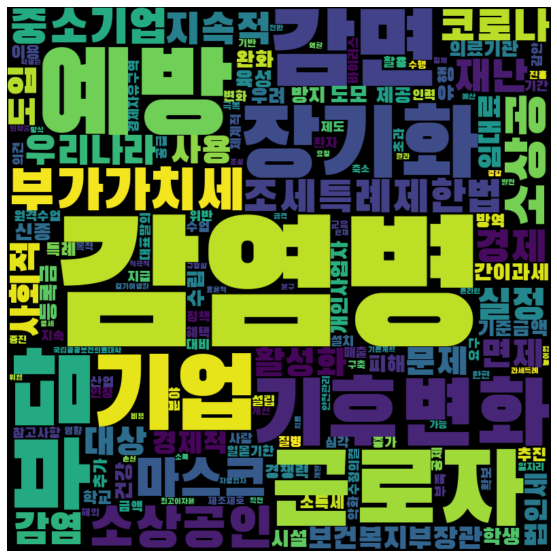

In [24]:
covid_tokens = total_tokens(covid['토큰'])
covid_tokens = [each_word for each_word in covid_tokens if each_word not in stopwords]

wordcloud_vis(covid_tokens)

## 3. 클러스터 별 분석

### ① 워드클라우드 

In [25]:
stopwords_ = ['법률','경우','것임','대한','신설','규정','현행법','사업','지원','위원회','관리','국가','해당','발생','관련','사항','있음’,’정책','일부','개정','최근',
                '집단','국내','의거','거나','함안','시행','이하','기한', '위해', '장관', '특별법', '마련','제호','임안','조사','운영','기관', '또한', '포함', '내용', 
                 '명시', '촉진', '근거', '실시', '지정', '현행', '의무', '확인', '도지사', '대통령령', '업무', '제출','대해', '제조','제항', '일부개정법률안','조제항',
                 '제조의제항','관련','만원','천만원','억원','연장함','해당','제조제항제호','법률','신설','이하','시행','사항','제호','포함','코로나바이러스감염증','일부개정법률안의안번호',
                 '비롯','곳곳','허영','필요','상황','적용','대면중소벤처기업','정부','이후','규정하','조정','상향','의결','법률안','어려움','제기','감소','사태','조치','강화',
            '국민','보호','지역','확대','지방자치단체','확산','대응','이상','기준','지적','위축','수준','필요성','범위','전제','연장','감염병','예방','재난','보건복지부장관','실정',
             '부담','수립','유행','방지','육성']

#### <0번 클러스터> - 코로나 사태에 대응하기 위한 세금문제 관련 의안

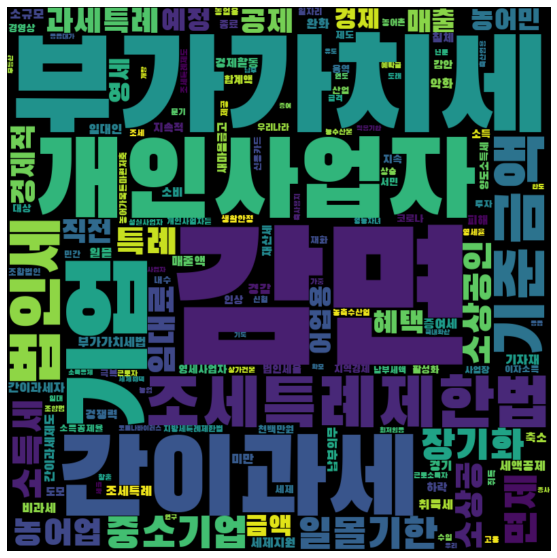

In [26]:
covid_0_tokens = total_tokens(covid_0['토큰'])
covid_0_tokens = [each_word for each_word in covid_0_tokens if each_word not in stopwords_]

wordcloud_vis(covid_0_tokens)

#### <1번 클러스터> - 코로나의 원인이라고 추정되는 '기후변화'문제에 대한 의안

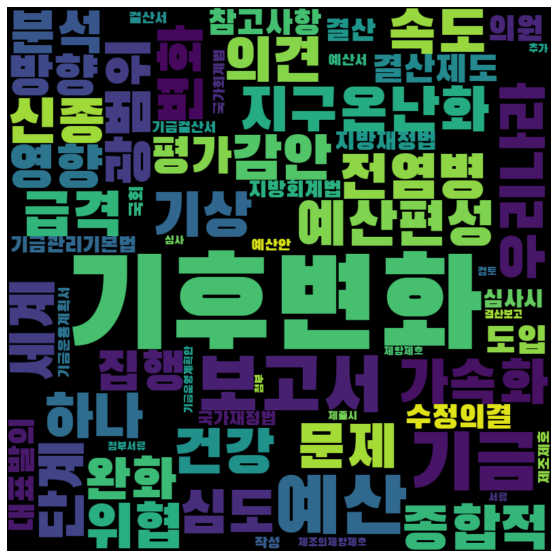

In [27]:
covid_1_tokens = total_tokens(covid_1['토큰'])
covid_1_tokens = [each_word for each_word in covid_1_tokens if each_word not in stopwords_]

wordcloud_vis(covid_1_tokens)

#### <2번 클러스터> - 코로나 감염 예방 및 대응 관련 의안

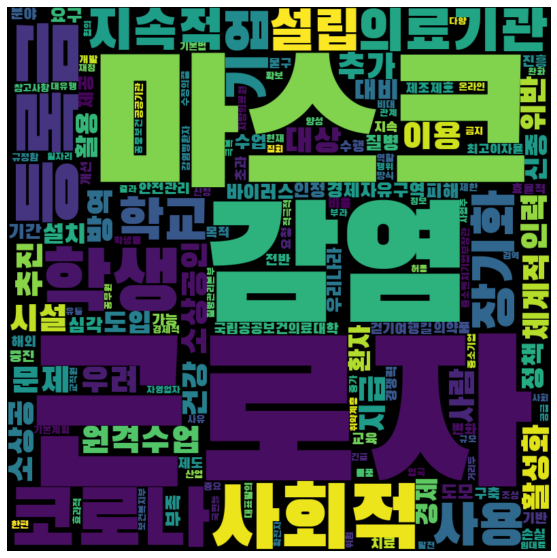

In [28]:
covid_2_tokens = total_tokens(covid_2['토큰'])
covid_2_tokens = [each_word for each_word in covid_2_tokens if each_word not in stopwords_]

wordcloud_vis(covid_2_tokens)

### ② 월별 법안 발의 건수

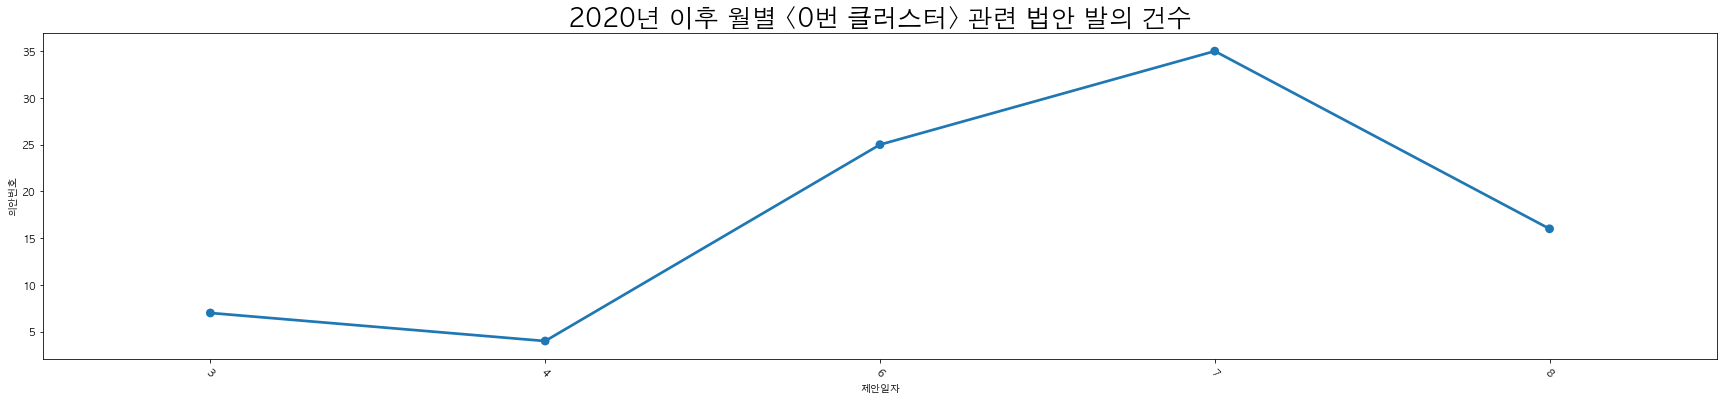

In [29]:
billdate_vis(covid_0, '<0번 클러스터>')

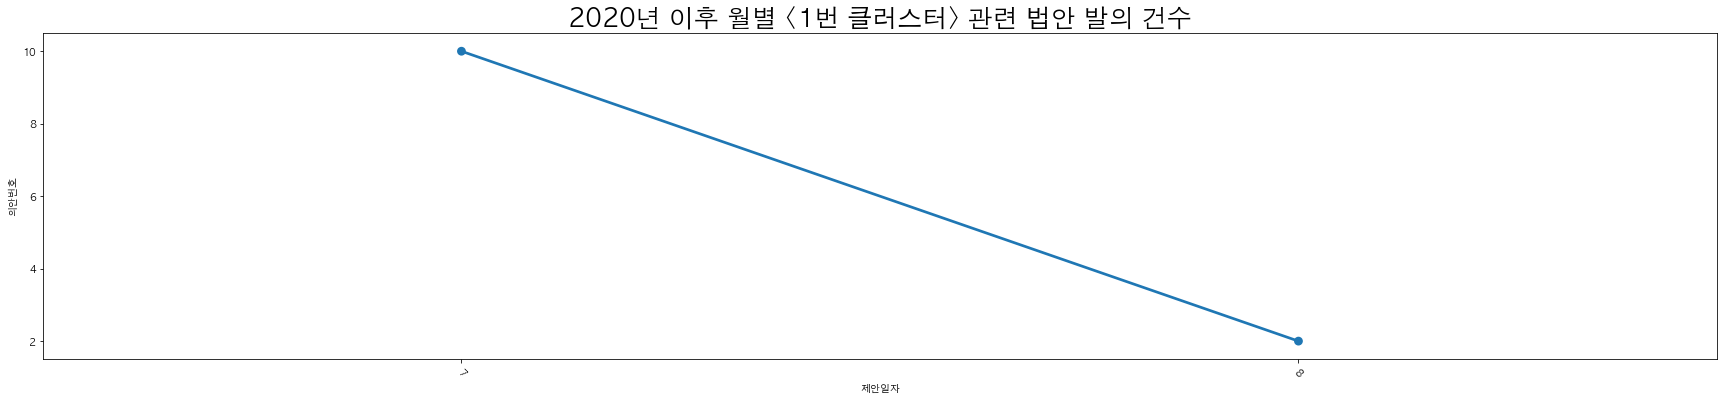

In [30]:
billdate_vis(covid_1, '<1번 클러스터>')

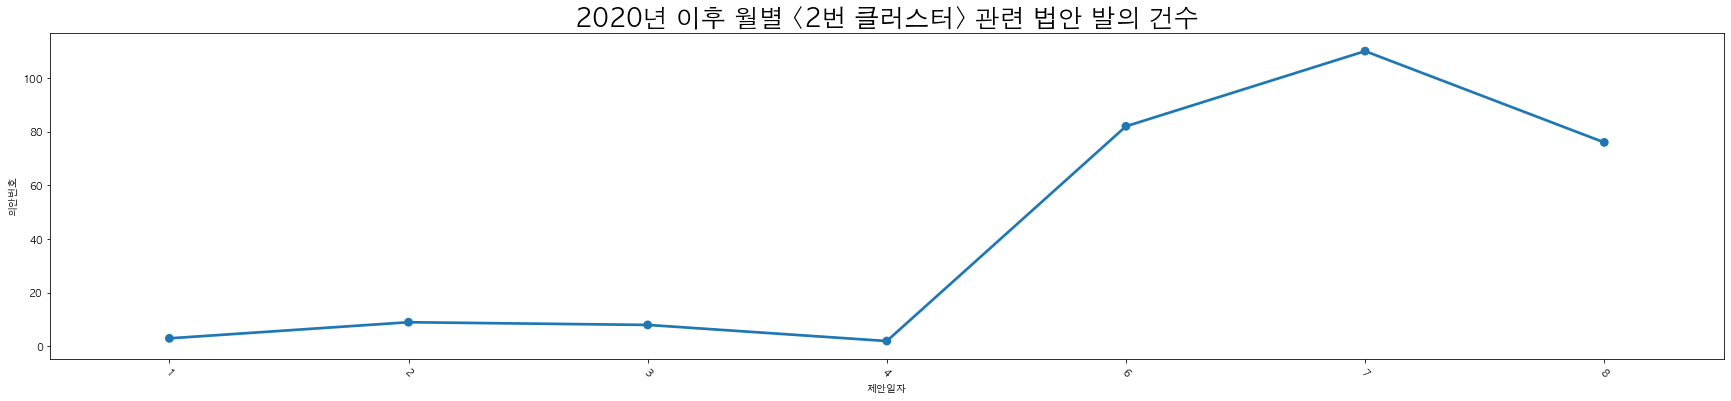

In [31]:
billdate_vis(covid_2, '<2번 클러스터>')